# Distributions

*Purpose*: We will use distributions to model uncertain quantities. Distributions (and densities, random variables) are useful mathematical objects, but we will need to understand their properties to use them as effective models. This exercise is about distributions and their fundamental properties: In a future exercise (`e-grama06-fit-univar`) we will discuss how to model real quantities with distributions.


## Setup


In [1]:
import grama as gr
import numpy as np
DF = gr.Intention()
%matplotlib inline

# Motivation: Modeling Uncertainty

Before we discuss distributions, let's first talk about *why* distributions are necessary and useful.

## To Summarize Data

A distribution is one way to *summarize* a dataset. Rather than using a (potentially large) dataset to describe a variable quantity, we can use a distribution.

Let's look at a specific dataset of die cast aluminum material properties.


In [2]:
from grama.data import df_shewhart


If we inspect the `tensile_strength` values, we can see that they are quite variable.


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


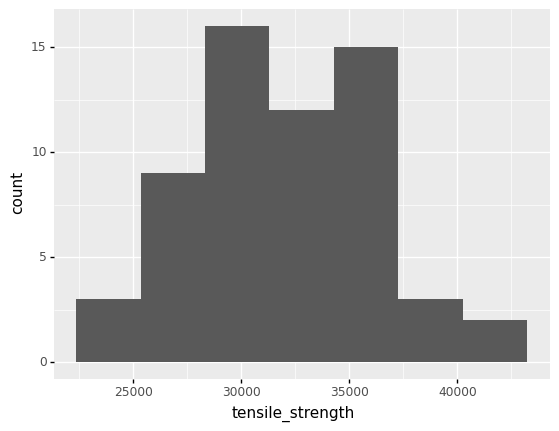

<ggplot: (8787877462468)>

In [3]:
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram()
)

Fitting a lognormal distribution allows us to summarize this variability. The following code fits a lognormal distribution to the `tensile_strength` data.


In [4]:
# Fit a lognormal distribution
mg_tensile_strength = gr.marg_fit(
    "lognorm",
    df_shewhart.tensile_strength,
    floc=0,
)
# Show a summary
mg_tensile_strength

(+0) lognorm, {'mean': '3.187e+04', 's.d.': '4.019e+03', 'COV': 0.13, 'skew.': 0.38, 'kurt.': 3.26}

The distribution is defined in terms of a handful of *parameters*---scalar values that affect the quantitative properties of the distribution.

When we compare the fitted distribution against the data, we can see that the fitted distribution is in the same location and has the same width as the data.


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


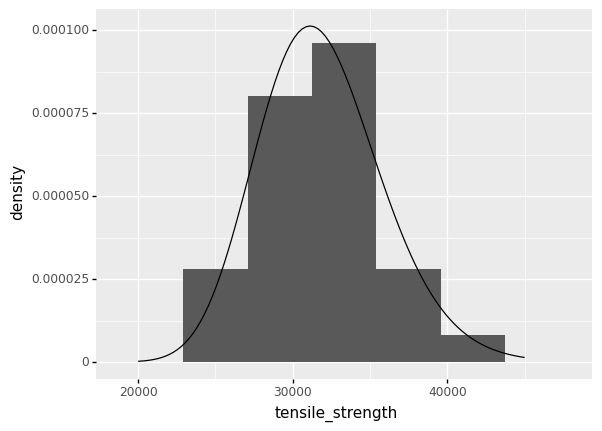

<ggplot: (8787855787876)>

In [5]:
# Visualize the density against the data
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(gr.aes(y=gr.after_stat("density")))
    + gr.geom_line(
        data=gr.df_make(tensile_strength=gr.linspace(20e3, 45e3, 100))
        >> gr.tf_mutate(d=mg_tensile_strength.d(DF.tensile_strength)),
        mapping=gr.aes(y="d")
    )
)

## To Make Assumptions Explicit

Selecting a distribtion helps us make assumptions about an uncertain quantity explicit. For instance, are we assuming that values are strictly bounded between low and high values? Or are there no bounds? 

For example, a normal distribution can take all values between $-\infty$ and $+\infty$, while a beta distribution has a finite width. The following visual compares the two distribution shapes.


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


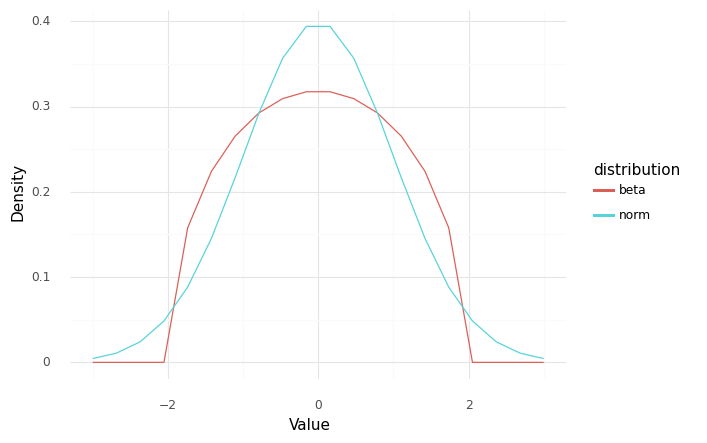

<ggplot: (8787838838306)>

In [21]:
# Normal is unbounded
mg_norm = gr.marg_mom("norm", mean=0, sd=1)
# Beta is strictly bounded
mg_beta = gr.marg_mom("beta", mean=0, sd=1, skew=0, kurt=2)

(
    gr.df_make(x=gr.linspace(-3, +3, 20))
    >> gr.tf_mutate(
        d_norm=mg_norm.d(DF.x),
        d_beta=mg_beta.d(DF.x),
    )
    >> gr.tf_pivot_longer(
        columns=["d_norm", "d_beta"],
        names_to=[".value", "distribution"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("x", "d", color="distribution"))
    + gr.geom_line()
    + gr.theme_minimal()
    + gr.labs(
        x="Value",
        y="Density",
    )
)

# Distribution Fundamentals

*Note*: In this exercise, to keep things simple, we will focus on distributions for *continuous* variable.


## What a distribution represents

*Fundamentally*, a distribution describes an uncertain value *in a quantitative fashion*. Rather than simply saying "I don't know what value this is," with a distribution we can express the fact that some values are more *likely* than others.

Distributions are particularly useful because they free us from "just" picking a single number. With a distribution we can get a lot more nuanced in our description of uncertain quantities. This exercise is all about using concepts about distributions to represent uncertain quantities, *and to do useful work*.


## Random variables

Clearly `tensile_strength` does not take a single value; therefore, we should think of `tensile_strength` as a *random variable*. A random variable is a mathematical object that we can use to model an uncertain quantity. Unlike a *deterministic variable* that has one fixed value (say $x = 1$), a random variable can take a different value each time we *observe* it. For instance, if $X$ were a random variable, and we used $X_i$ to denote the value that occurs on the $i$-th observation, then we might see a sequence like

$$X_1 = 1, X_2 = -3, X_3 = 1, X_4 = 5, \dots$$

What counts as an *observation* depends on what we are using the random variable to model. Essentially, an observation is an occurrence that gives us the potential to "see" a new value. 

Let's take a look at the `tensile_strength` example to get a better sense of these ideas.


For the `tensile_strength`, we saw a sequence of different values:

In [7]:
(
    df_shewhart
    >> gr.tf_head(4)
)

,specimen,tensile_strength,hardness,density
0,1,29314,53.0,2.666
1,2,34860,70.2,2.708
2,3,36818,84.3,2.865
3,4,30120,55.3,2.627


Every time we manufacture a new part, we perform a sequence of manufacturing steps that work together to "lock in" a particular value of `tensile_strength`. Those individual steps tend to go slightly differently each time we make a part (e.g. an operator calls in sick one day, we get a slightly more dense batch of raw material, it's a particularly hot summer day, etc.), so we end up with different properties in each part.

Given the complicated realities of manfacturing, it makes sense to think of an *observation* as being one complete run of the manufacturing process that generates a particular part with its own `tensile_strength`. This is what the `specimen` column in `df_shewhart` refers to; a unique identifier tracking individual runs of the complete manufacturing process, resulting in a unique part.


```{admonition} Nomenclature: A *realization* is like a single roll of a die
Some nomenclature: When we talk about random quantities, we use the term *realization* (or *observation*) to refer to a single event that yields a random value, according to a particular distribution. For instance, a single manufactured part will have a realized strength value. If we take multiple realizations, we will tend to see different values. For instance, we saw a large amount of variability among the realized `tensile_strength` values above.

A single realization tells us very little about how the distribution tends to behave, but a set of realizations (a *sample*) will give us a sense of how the random values tend to behave *collectively*. A distribution is a way to model that collective behavior.
```

## A distribution defines a random variable

**A distribution defines a random variable**. We say that a random variable $X$ is *distributed according to* a particular density $\rho$, and we express the same statement mathematically as

$$X \sim \rho.$$

One way to represent a distribution is with a *density function*. The following plot displays the density for a normal distribution:


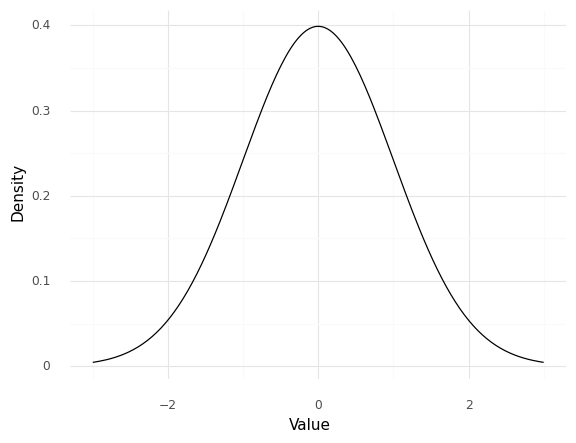

<ggplot: (8787878092023)>

In [24]:
## NOTE: No need to edit
# This visualizes a density function
(
    gr.df_make(x=gr.linspace(-3, +3, 200))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
    
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.theme_minimal()
    + gr.labs(
        x="Value",
        y="Density",
    )
)


The `Value` pictured here corresponds to all of the potential values that the random variable can take, while the `Density` quantitatively describes how likely (or unlikely) each of those values are. Density functions tend to "fall off" towards zero as we move towards more extreme values; these lower regions of the density are called "tails" of the distribution. The smallest values are associated with the "lower" or "left" tail, while the largest values are associated with the "upper" or "right" tail.


### __q1__ Define a distribution

Use the grama helper function `gr.marg_mom()` to define a distribution in terms of its *moments*. Fit a normal `"norm"` distribution with a mean of `1` and a standard deviation of `0.3`.


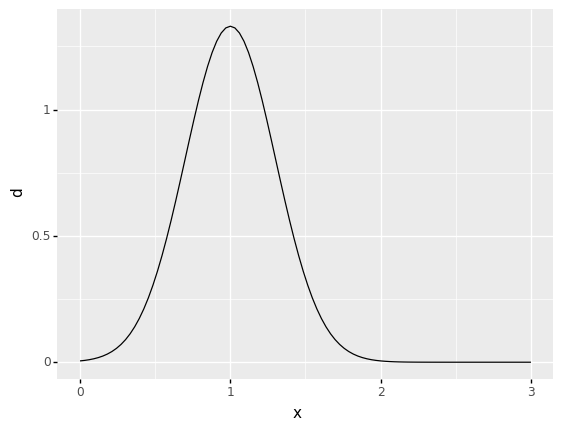

<ggplot: (8787877775439)>

In [8]:
## TASK: Define a normal distribution
# task-begin
mg_norm = None # Define the distribution here
# task-end
# solution-begin
mg_norm = gr.marg_mom("norm", mean=1, sd=0.3)
# solution-end

## NOTE: No need to edit; this will plot your distribution
(
    gr.df_make(x=gr.linspace(0, 3, 100))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
)

### __q2__ Check your distribution's summary

Print the distribution's summary by simply "executing" the distribution (like you would with a DataFrame or grama model).


In [9]:
## TASK: Print the summary of mg_norm
# solution-begin
mg_norm
# solution-end

(+0) norm, {'mean': '1.000e+00', 's.d.': '3.000e-01', 'COV': 0.3, 'skew.': 0.0, 'kurt.': 3.0}

*Observations*

<!-- task-begin -->
- What mean does your distribution have?
  - (Your response here)
- What value of *skewness* does your distribution have?
  - (Your response here)
- What value of *kurtosis* does your distribution have?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- What mean does your distribution have?
  - `mean = 1.0`
- What value of *skewness* does your distribution have?
  - `skewness = 0.0`
- What value of *kurtosis* does your distribution have?
  - `kurtosis = 3.0`
<!-- solution-end -->

## Moments

The summary of a distribution reports a few of its *moments*. These moments tell us different "facts" about the distribution:

| Moment | Meaning |
|--------|---------|
| Mean   | Location |
| Standard deviation | Width |
| Skewness | Left- or right-lopsidedness |
| Kurtosis | Tendency to produce extreme (large) values |

Note that the distribution summary also reports the *coefficient of variation* (COV), which is a normalized version of the standard deviation (`COV = sd / mean`).


### __q3__ Compare two distributions

Inspect the following distribution summaries and the plot. Answer the questions under *obervations* below.


(+0) norm, {'mean': '1.000e+00', 's.d.': '3.000e-01', 'COV': 0.3, 'skew.': 0.0, 'kurt.': 3.0}
(+0) lognorm, {'mean': '1.000e+00', 's.d.': '3.000e-01', 'COV': 0.3, 'skew.': 0.93, 'kurt.': 4.57}


/Users/zach/Git/py_grama/grama/tran_pivot.py:471: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


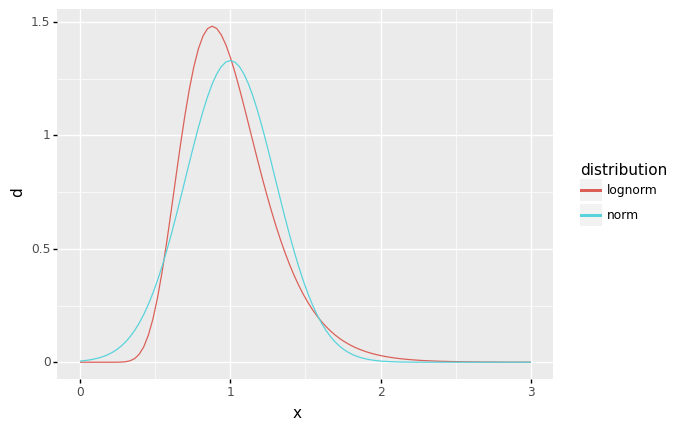

<ggplot: (8787877877941)>

In [20]:
## NOTE: No need to edit; this will plot your distribution
mg_lognorm = gr.marg_mom("lognorm", mean=1, sd=0.3, floc=0)

## Print the summaries
print(mg_norm)
print(mg_lognorm)

## Visualize the distributions
(
    gr.df_make(x=gr.linspace(0, 3, 100))
    >> gr.tf_mutate(
        d_norm=mg_norm.d(DF.x),
        d_lognorm=mg_lognorm.d(DF.x),
    )
    >> gr.tf_pivot_longer(
        columns=["d_norm", "d_lognorm"],
        names_to=[".value", "distribution"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("x", "d", color="distribution"))
    + gr.geom_line()
)

*Observations*

<!-- task-begin -->
- What is the `skew.` of the `norm` distribution? How does that compare with the `skew` of the `lognorm` distribution?
  - (Your response here)
- Skewness is related to asymmetry of a distribution: In your own words, how is the lognormal distribution above asymmetric?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- What is the `skew.` of the `norm` distribution? How does that compare with the `skew` of the `lognorm` distribution?
  - The `norm` distribution has `skew. == 0`, while the `lognorm` distribution has `skew. == 0.93`.
- Skewness is related to asymmetry of a distribution: In your own words, how is the lognormal distribution above asymmetric?
  - The lognormal distribution has a "longer" right tail
<!-- solution-end -->

### __q4__ *Draw* random values from your distribution

Use the `Marginal.r(n)` method to *draw* `1000` random values from your distribution. Play with the sample size `n`, and answer the questions under *observations* below.

*Hint*: A *method* is a function that you invoke using dot notation. If the marginal were named `mg`, then you could call the random value method via `mg.r(1000)`.


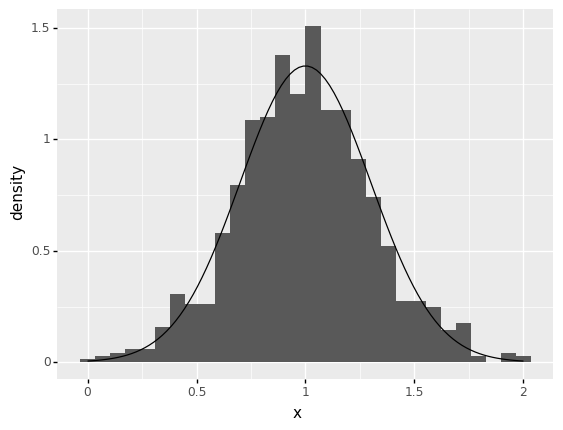

<ggplot: (8787890079585)>

In [10]:
## TASK: Draw 1000 random values from mg_norm
# task-begin
X = None # TODO: Replace with 1000 random values
# task-end
# solution-begin
X = mg_norm.r(1000)
# solution-end

## NOTE: No need to edit; use this to check your answer
(
    gr.df_make(x=X)
    >> gr.ggplot(gr.aes("x"))
    + gr.geom_histogram(bins=30, mapping=gr.aes(y="stat(density)"))
    + gr.geom_line(
        data=gr.df_make(x=gr.linspace(0, 2, 100))
        >> gr.tf_mutate(d=mg_norm.d(DF.x)),
        mapping=gr.aes(y="d")
    )
)

*Observations*

<!-- task-begin -->
- Set `n` to a small value (say `n=100`). How well does the histogram match the density?
  - (Your response here)
- What value of `n` is necessary for the histogram to resemble the density?
  - (Your response here)
<!-- task-end -->
<!-- task-begin -->
- Set `n` to a small value (say `n=100`). How well does the histogram match the density (soid curve)?
  - The histogram really does not resemble the density at all....
- What value of `n` is necessary for the histogram to resemble the density?
  - I find that a modestly-large value (around `n=1000`) is necessary for the histogram to resemble the density.
<!-- task-end -->

## Mean (aka Expectation)

The mean

$$\overline{X} = \frac{1}{n} \sum_{i=1}^n X_i$$

$$\mathbb{E}[X] = \lim_{n\to\infty} \frac{1}{n} \sum_{i=1}^n X_i$$


### __qX__ Estimate a (sample) mean


In [11]:
(
    gr.df_make(x=mg_norm.r(100))
# solution-begin
    >> gr.tf_summarize(
        x_mean=gr.mean(DF.x)
    )
# solution-end
)

,x_mean
0,0.952582


*Observations*

<!-- task-begin -->
- How does the sample mean compare with the true mean of your distribution `mg_norm`?
  - (Your response here)
- What might account for this difference?
  - (Your response here)
- Re-run the cell; do you get an identical value?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How does the sample mean compare with the true mean of your distribution `mg_norm`?
  - The value is different each time, but I get a value quite close to `1.0`, the true mean.
- What might account for this difference?
  - We took a limited sample $n < \infty$, thus there is sampling error in the estimated mean.
- Re-run the cell; do you get an identical value?
  - Nope! There is randomness in the estimate.
<!-- solution-end -->

## Probability

Probability is the area under the curve, within a set of interest. For instance, if we were interested in the probability that $0.5 <= X <= 0.7$, the following area would be the probability:


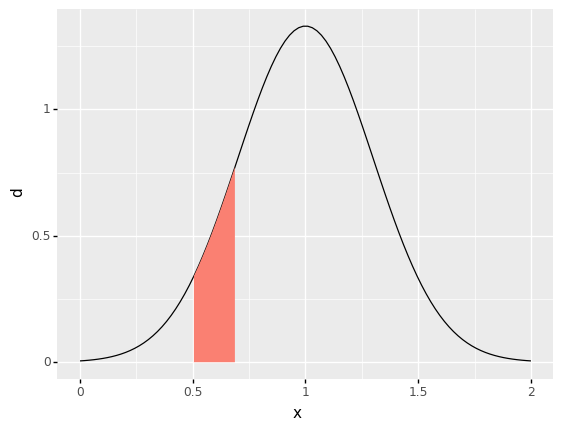

<ggplot: (8787890139814)>

In [12]:
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 100))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_ribbon(
        data=df_tmp
        >> gr.tf_filter(0.5 <= DF.x, DF.x <= 0.7),
        mapping=gr.aes(ymin=0, ymax="d"),
        fill="salmon",
        color=None,
    )
)

Note that probability is associated with a *set*---a range of values---not just a single value. Note that the area under the curve for a single value would have zero width, hence zero probability!


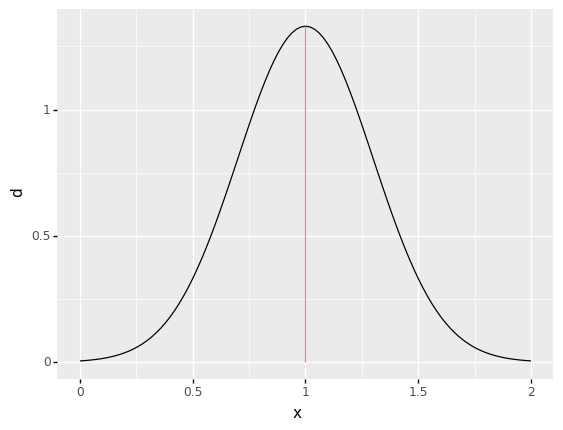

<ggplot: (8787856019035)>

In [13]:
df_tmp = (
    gr.df_make(x=gr.linspace(0, 2, 101))
    >> gr.tf_mutate(d=mg_norm.d(DF.x))
)

(
    df_tmp
    >> gr.ggplot(gr.aes("x", "d"))
    + gr.geom_line()
    + gr.geom_segment(
        data=df_tmp
        >> gr.tf_filter(DF.x == gr.median(DF.x)),
        mapping=gr.aes(xend="x", yend=0),
        color="salmon",
    )
)

A more mathematical definition for probability is in terms of the expectation

$$\mathbb{P}[X \in A] = \mathbb{E}[1(X \in A)]$$

where $1(X \in A)$ is the *indicator function*, which is just a fancy way of tracking whether or not a point lands in the set $A$. The function takes values $1,0$ depending on whether or not a value $X$ lands inside the set $A$.

$$1(X \in A) = \left\{\begin{array}{cc} 1 & \text{ if }X \in A \\ 0 & \text{ otherwise}\end{array}\right.$$

This expectation definition is not just math for its own sake; this expectation of the indicator definition is **easy to translate into computer code**.


### __qX__ Compute an indicator


In [14]:


df_ind = (
    gr.df_make(x=mg_norm.r(100))
# task-begin
    ## Compute the indicator function, call it "ind"
# task-end
# solution-begin
    >> gr.tf_mutate(
        ind=DF.x <= 1,
    )
# solution-end
)

# NOTE: No need to edit; use this to check your work
assert \
    "ind" in df_ind.columns, \
    "The result df_ind does not have an indicator column `ind`"

assert \
    (all(df_ind.ind == (df_ind.x <= 1))), \
    "Your indicator column `ind` is incorrect."

### __qX__ Estimate a probability


In [15]:
(
    df_ind
# solution-begin
    >> gr.tf_summarize(pr=gr.mean(DF.ind))
# solution-end
)

,pr
0,0.48


### __qX__ Estimate a probability of failure


## Quantiles

Quantiles "turn around" the idea of probability. With probability we start with a set $A$ and arrive at a probability value $p$. With a *quantile* we start with a probability value $p$ and arrive at a single value $q$.


### __qX__ Compute a quantile


In [16]:
# task-begin
q_10 = None
q_50 = None
# task-end
# solution-begin
q_10 = mg_norm.q(0.10)
q_50 = mg_norm.q(0.50)
# solution-end

# NOTE: No need to edit; use this to check your work
(
    gr.df_make(x=mg_norm.r(1000))
    >> gr.tf_summarize(
        pr_10=gr.mean(DF.x <= q_10), # Should be around 0.10
        pr_50=gr.mean(DF.x <= q_50), # Should be around 0.50
    )
)

,pr_10,pr_50
0,0.108,0.51


### __qX__ Estimate a conservative strength


In [17]:
(
    df_shewhart 
# solution-begin
    >> gr.tf_summarize(
        lower=gr.quant(DF.tensile_strength, 0.10),
        mean=gr.mean(DF.tensile_strength),
    )
# solution-end
)

,lower,mean
0,26395.0,31869.366667


*Observations*

<!-- task-begin -->
- Suppose the observed variability in the `tensile_strength` is real. Which of `mean` or `lower` is safer to use for design purposes? Why?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Suppose the observed variability in the `tensile_strength` is real. Which of `mean` or `lower` is safer to use for design purposes? Why?
  - If the variability is real, then `lower` is definitely safer for design. Real variability means that parts can end up with a strength lower than the `mean`; thus if we design assuming the `mean` value, real parts may end up failing.
<!-- solution-end -->
